In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

bigPath = '/home/aashinshazar/beta/cookiesinthejar/'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    part_files = np.array(data['filenames'])
    part_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return part_files, part_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(bigPath + 'train')
test_files, test_targets = load_dataset(bigPath +'test')
valid_files, valid_targets = load_dataset(bigPath +'valid')

print('There are %d training part images.' % len(train_files))
print('There are %d validation part images.' % len(valid_files))
print('There are %d test part images.'% len(test_files))

Using TensorFlow backend.


There are 450 training part images.
There are 29 validation part images.
There are 100 test part images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 100/100 [00:00<00:00, 215.39it/s]


In [18]:
from keras.applications import InceptionResNetV2

from keras.utils import multi_gpu_model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense

from keras import applications

numGPU = 2
image_size = 224

#Load the VGG model
vgg_conv = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten(input_shape=(image_size, image_size, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

<keras.engine.input_layer.InputLayer object at 0x7f0d83193160> False
<keras.layers.convolutional.Conv2D object at 0x7f0d831933c8> False
<keras.layers.normalization.BatchNormalization object at 0x7f0d831938d0> False
<keras.layers.core.Activation object at 0x7f0d831932e8> False
<keras.layers.convolutional.Conv2D object at 0x7f0d83193278> False
<keras.layers.normalization.BatchNormalization object at 0x7f0d831958d0> False
<keras.layers.core.Activation object at 0x7f0d83195be0> False
<keras.layers.convolutional.Conv2D object at 0x7f0d8309f358> False
<keras.layers.normalization.BatchNormalization object at 0x7f0d830725c0> False
<keras.layers.core.Activation object at 0x7f0d83072278> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0d82f84e10> False
<keras.layers.convolutional.Conv2D object at 0x7f0d82f84fd0> False
<keras.layers.normalization.BatchNormalization object at 0x7f0d82edae48> False
<keras.layers.core.Activation object at 0x7f0d82edaf60> False
<keras.layers.convolutional.Conv

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_4 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               9830656   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 514       
Total params: 64,167,906
Trainable params: 9,831,170
Non-trainable params: 54,336,736
_________________________________________________________________


In [19]:
from keras.callbacks import ModelCheckpoint
import time

import matplotlib.pyplot as plt
import numpy

epochs = 100
batch_size=20

bestModelSavedName = "InceptionResNetV2_frozen.hdf5"

checkpointer = ModelCheckpoint(filepath=bestModelSavedName, 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets), 
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=2)

Train on 450 samples, validate on 29 samples
Epoch 1/100
 - 19s - loss: 6.4114 - acc: 0.5467 - val_loss: 9.3820 - val_acc: 0.3966

Epoch 00001: val_loss improved from inf to 9.38203, saving model to InceptionResNetV2_frozen.hdf5
Epoch 2/100
 - 2s - loss: 5.5047 - acc: 0.5956 - val_loss: 6.6867 - val_acc: 0.5345

Epoch 00002: val_loss improved from 9.38203 to 6.68666, saving model to InceptionResNetV2_frozen.hdf5
Epoch 3/100
 - 2s - loss: 5.1487 - acc: 0.6178 - val_loss: 4.7200 - val_acc: 0.6552

Epoch 00003: val_loss improved from 6.68666 to 4.72002, saving model to InceptionResNetV2_frozen.hdf5
Epoch 4/100
 - 2s - loss: 3.9549 - acc: 0.6867 - val_loss: 7.8276 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 4.72002
Epoch 5/100
 - 2s - loss: 3.2511 - acc: 0.7511 - val_loss: 2.4902 - val_acc: 0.8448

Epoch 00005: val_loss improved from 4.72002 to 2.49017, saving model to InceptionResNetV2_frozen.hdf5
Epoch 6/100
 - 2s - loss: 3.3523 - acc: 0.7400 - val_loss: 2.2732 - val_ac


Epoch 00057: val_loss did not improve from 2.01221
Epoch 58/100
 - 2s - loss: 0.1630 - acc: 0.9767 - val_loss: 2.7064 - val_acc: 0.8103

Epoch 00058: val_loss did not improve from 2.01221
Epoch 59/100
 - 2s - loss: 0.0508 - acc: 0.9933 - val_loss: 2.9683 - val_acc: 0.7931

Epoch 00059: val_loss did not improve from 2.01221
Epoch 60/100
 - 2s - loss: 0.1965 - acc: 0.9678 - val_loss: 2.9148 - val_acc: 0.7931

Epoch 00060: val_loss did not improve from 2.01221
Epoch 61/100
 - 2s - loss: 0.3818 - acc: 0.9633 - val_loss: 2.0969 - val_acc: 0.8276

Epoch 00061: val_loss did not improve from 2.01221
Epoch 62/100
 - 2s - loss: 0.1049 - acc: 0.9822 - val_loss: 3.2602 - val_acc: 0.7931

Epoch 00062: val_loss did not improve from 2.01221
Epoch 63/100
 - 2s - loss: 0.2470 - acc: 0.9633 - val_loss: 3.0781 - val_acc: 0.7586

Epoch 00063: val_loss did not improve from 2.01221
Epoch 64/100
 - 2s - loss: 0.1549 - acc: 0.9767 - val_loss: 3.3168 - val_acc: 0.7931

Epoch 00064: val_loss did not improve fr

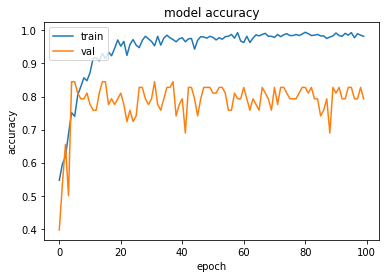

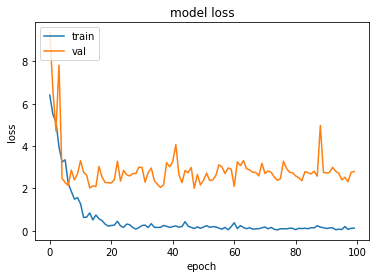

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
from sklearn.metrics import f1_score
import pandas as pd

model.load_weights('/home/aashinshazar/' + bestModelSavedName)

# get index of predicted part for each image in the test image set
part_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(part_predictions)==np.argmax(test_targets, axis=1))/len(part_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

print ("Fscore:", f1_score(np.argmax(test_targets, axis=1), part_predictions, average=None) )

y_actu = pd.Series(np.argmax(test_targets, axis=1), name='Actual')
y_pred = pd.Series(part_predictions, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

Test accuracy: 69.0000%
Fscore: [0.69306931 0.68686869]
Predicted   0   1  All
Actual                
0          35  28   63
1           3  34   37
All        38  62  100
